### Import libraries

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E78_copy)

array([-5.6, -5.6, -5.6, ..., -6.5, -6.5, -6.5])

### Selecting EEG signals

In [6]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 200
bis_end_index = 800

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-14.8  -12.6  -13.1  ... -21.3  -21.8  -20.45]


### Bandpass filtering

In [7]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)


### Variational Mode Decomposition (VMD)

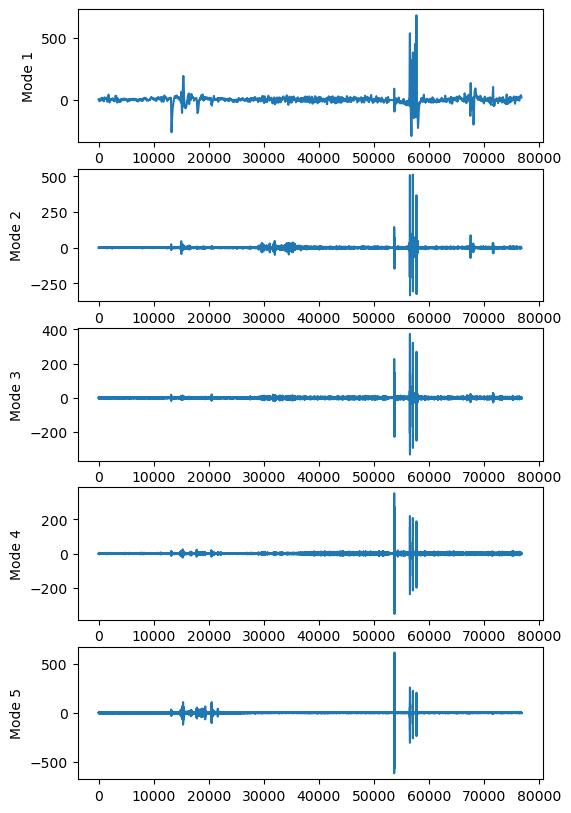

In [99]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

In [98]:
selected_EEG.shape

(76800,)

### Windowing and features extraction

Number of BIS: 545


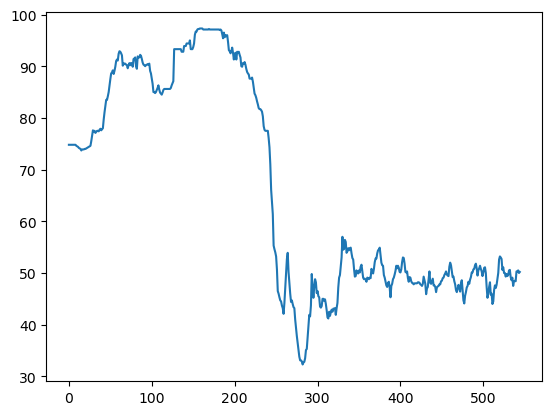

In [9]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [10]:
# For mean and standard deviation

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    windows = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        windows.append(window)
        #window_start += stride
        
        
        if method == "mean":
            # Calculate sample entropy within the window
            results = np.mean(windows, axis=1)
            


        if method == "std":
            # Calculate sample entropy within the window
            results = np.std(windows, axis=1)

    return results

In [12]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
print(f"Number of features:", len(results_0))


# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_1))

# Example usage
data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_2))

# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_3))

# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
results_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
#print(f"Number of features:", len(results_4))

Number of features: 545


Number of features: 545


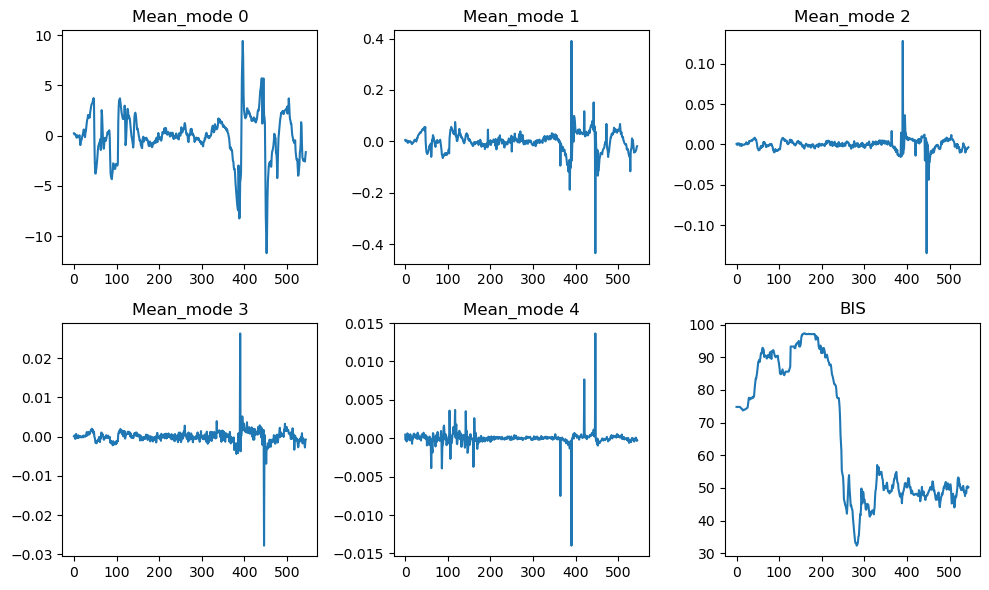

In [13]:
print(f"Number of features:", len(results_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(results_0)
axes[0, 0].set_title('Mean_mode 0')

# Plot on the second subplot
axes[0, 1].plot(results_1)
axes[0, 1].set_title('Mean_mode 1')

# Plot on the third subplot
axes[0, 2].plot(results_2)
axes[0, 2].set_title('Mean_mode 2')

axes[1, 0].plot(results_3)
axes[1, 0].set_title('Mean_mode 3')

axes[1, 1].plot(results_4)
axes[1, 1].set_title('Mean_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


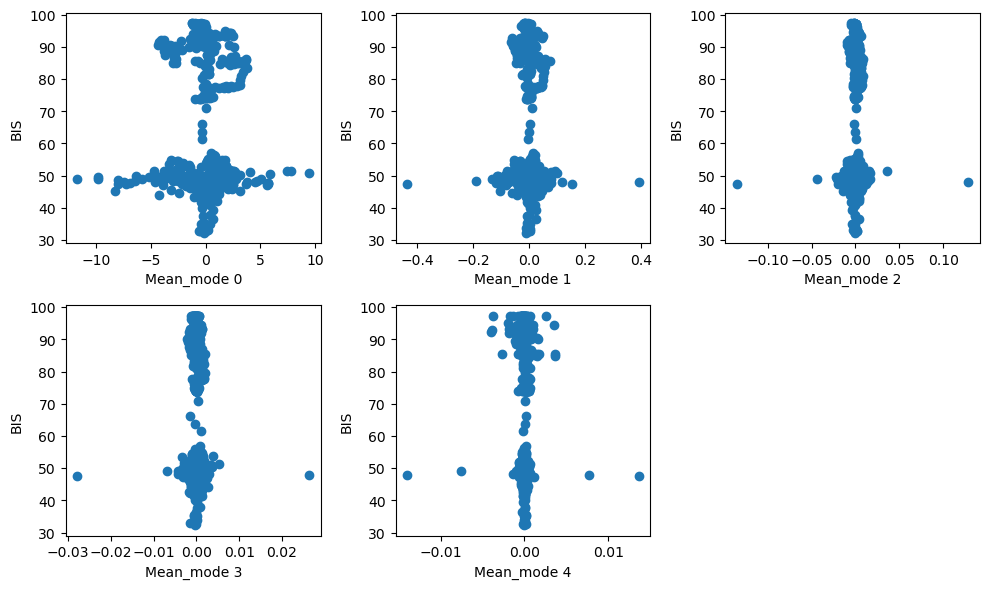

In [14]:

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].scatter(results_0, bis_windows)
axes[0, 0].set_xlabel('Mean_mode 0')
axes[0, 0].set_ylabel('BIS')

# Plot on the second subplot
axes[0, 1].scatter(results_1, bis_windows)
axes[0, 1].set_xlabel('Mean_mode 1')
axes[0, 1].set_ylabel('BIS')

# Plot on the third subplot
axes[0, 2].scatter(results_2, bis_windows)
axes[0, 2].set_xlabel('Mean_mode 2')
axes[0, 2].set_ylabel('BIS')

axes[1, 0].scatter(results_3, bis_windows)
axes[1, 0].set_xlabel('Mean_mode 3')
axes[1, 0].set_ylabel('BIS')

axes[1, 1].scatter(results_4, bis_windows)
axes[1, 1].set_xlabel('Mean_mode 4')
axes[1, 1].set_ylabel('BIS')


fig.delaxes(axes[1, 2])

# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [48]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
print(f"Number of features:", len(result_0))


# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_1))

data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds  
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_2))

# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_3))

# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='std')
#print(f"Number of features:", len(result_4))


Number of features: 0


Number of features: 545


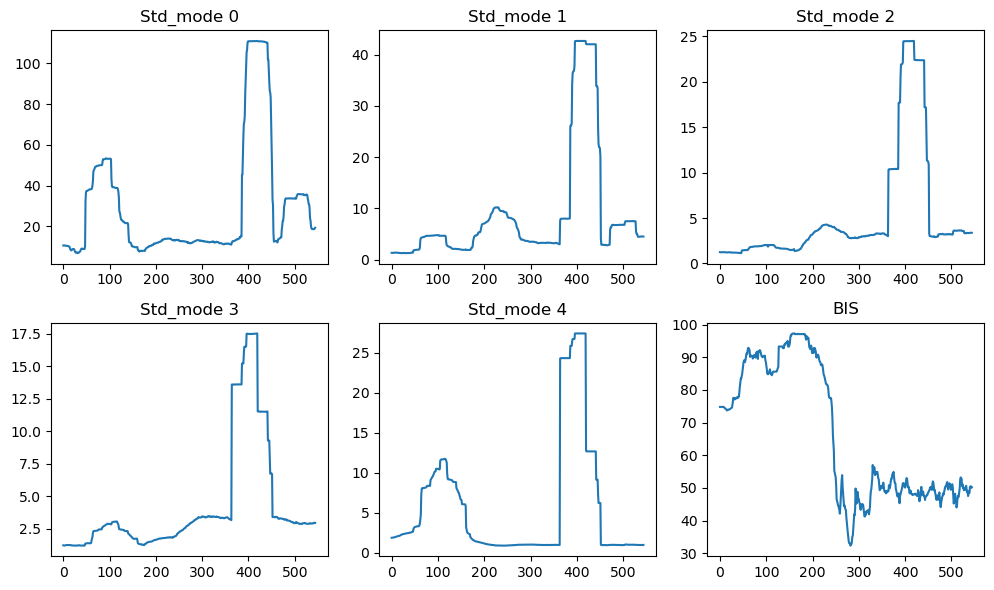

In [16]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(result_0)
axes[0, 0].set_title('Std_mode 0')

# Plot on the second subplot
axes[0, 1].plot(result_1)
axes[0, 1].set_title('Std_mode 1')

# Plot on the third subplot
axes[0, 2].plot(result_2)
axes[0, 2].set_title('Std_mode 2')

axes[1, 0].plot(result_3)
axes[1, 0].set_title('Std_mode 3')

axes[1, 1].plot(result_4)
axes[1, 1].set_title('Std_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


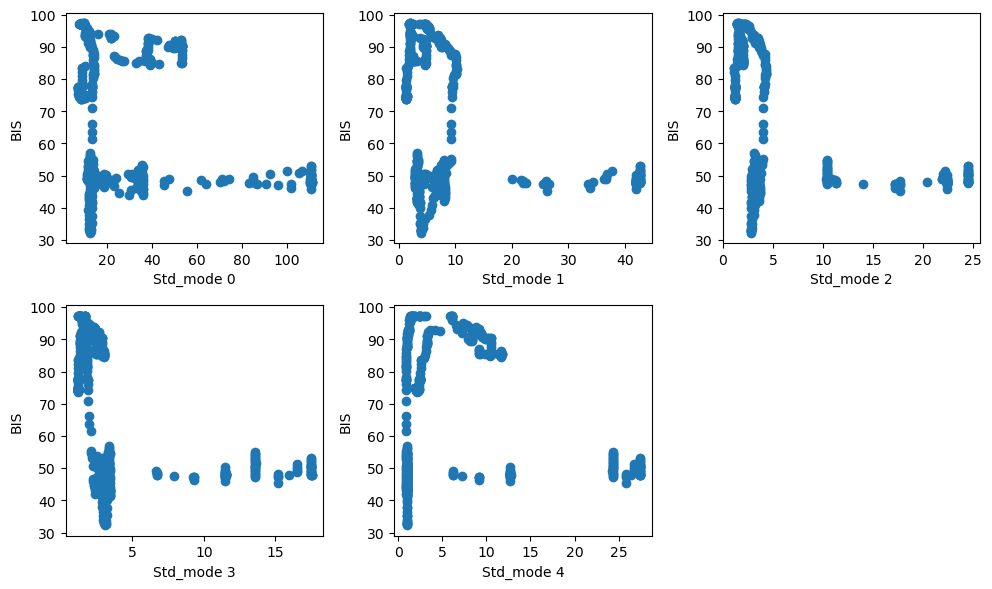

In [17]:

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].scatter(result_0, bis_windows)
axes[0, 0].set_xlabel('Std_mode 0')
axes[0, 0].set_ylabel('BIS')

# Plot on the second subplot
axes[0, 1].scatter(result_1, bis_windows)
axes[0, 1].set_xlabel('Std_mode 1')
axes[0, 1].set_ylabel('BIS')

# Plot on the third subplot
axes[0, 2].scatter(result_2, bis_windows)
axes[0, 2].set_xlabel('Std_mode 2')
axes[0, 2].set_ylabel('BIS')

axes[1, 0].scatter(result_3, bis_windows)
axes[1, 0].set_xlabel('Std_mode 3')
axes[1, 0].set_ylabel('BIS')

axes[1, 1].scatter(result_4, bis_windows)
axes[1, 1].set_xlabel('Std_mode 4')
axes[1, 1].set_ylabel('BIS')


fig.delaxes(axes[1, 2])

# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [91]:
# For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            sample_entropy = ant.sample_entropy(window)
            result.append(sample_entropy)


        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)

    return result


In [76]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsa_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
print(f"Number of features:", len(resultsa_0))

# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsa_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
#print(f"Number of features:", len(resultsa_1))

# Example usage
data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsa_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
#print(f"Number of features:", len(resultsa_2))

# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsa_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
#print(f"Number of features:", len(resultsa_3))

# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsa_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
#print(f"Number of features:", len(resultsa_4))

Number of features: 545


Number of features: 0


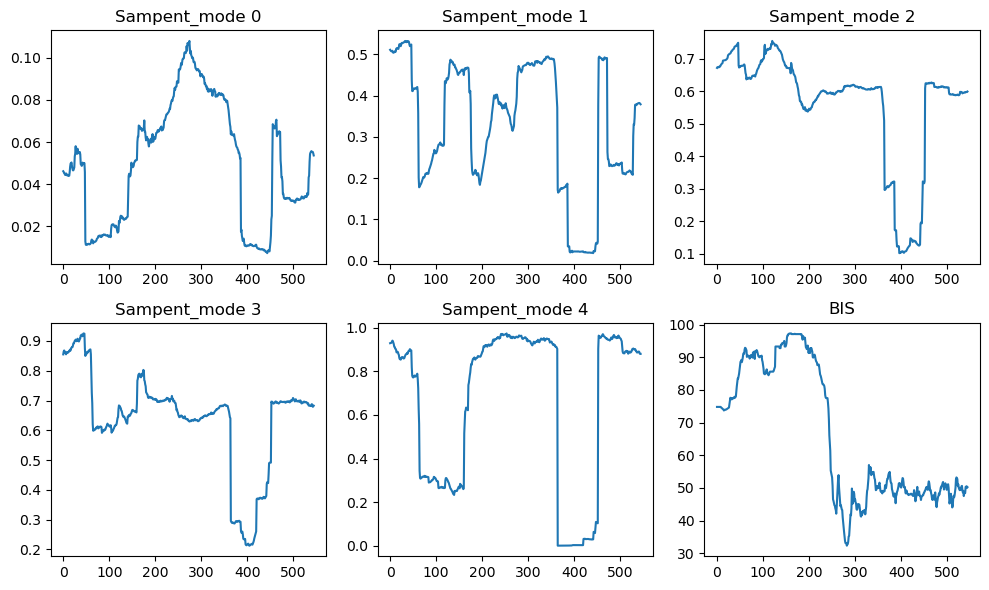

In [77]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsa_0)
axes[0, 0].set_title('Sampent_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsa_1)
axes[0, 1].set_title('Sampent_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsa_2)
axes[0, 2].set_title('Sampent_mode 2')

axes[1, 0].plot(resultsa_3)
axes[1, 0].set_title('Sampent_mode 3')

axes[1, 1].plot(resultsa_4)
axes[1, 1].set_title('Sampent_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


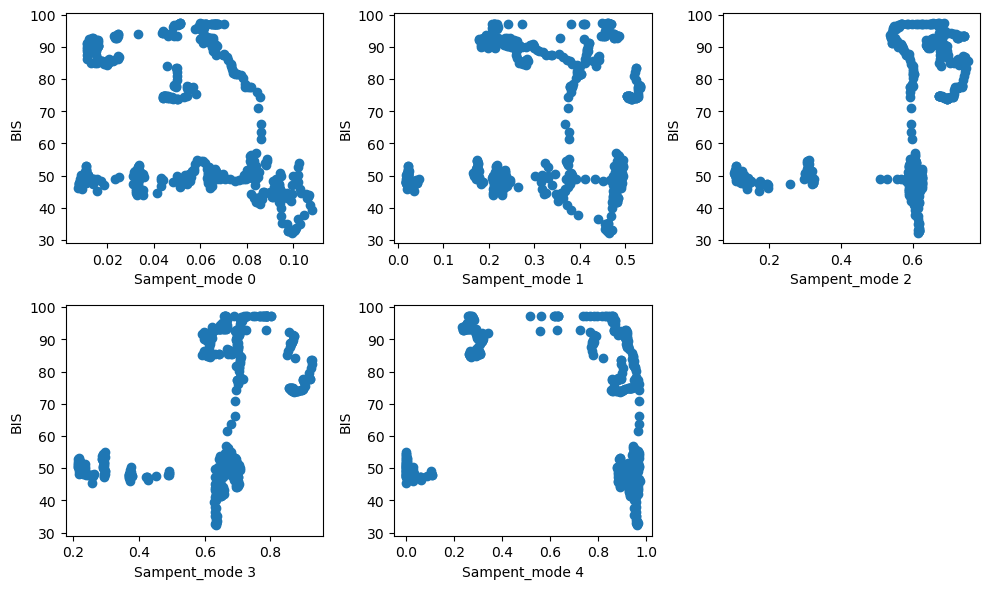

In [78]:

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].scatter(resultsa_0, bis_windows)
axes[0, 0].set_xlabel('Sampent_mode 0')
axes[0, 0].set_ylabel('BIS')

# Plot on the second subplot
axes[0, 1].scatter(resultsa_1, bis_windows)
axes[0, 1].set_xlabel('Sampent_mode 1')
axes[0, 1].set_ylabel('BIS')

# Plot on the third subplot
axes[0, 2].scatter(resultsa_2, bis_windows)
axes[0, 2].set_xlabel('Sampent_mode 2')
axes[0, 2].set_ylabel('BIS')

axes[1, 0].scatter(resultsa_3, bis_windows)
axes[1, 0].set_xlabel('Sampent_mode 3')
axes[1, 0].set_ylabel('BIS')

axes[1, 1].scatter(resultsa_4, bis_windows)
axes[1, 1].set_xlabel('Sampent_mode 4')
axes[1, 1].set_ylabel('BIS')


fig.delaxes(axes[1, 2])

# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [79]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
print(f"Number of features:", len(resultsp_0))


# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsp_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
#print(f"Number of features:", len(resultsp_1))


# Example usage
data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsp_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
#print(f"Number of features:", len(resultsp_2))


# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsp_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
#print(f"Number of features:", len(resultsp_3))


# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsp_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
#print(f"Number of features:", len(resultsp_4))



Number of features: 545


Number of features: 0


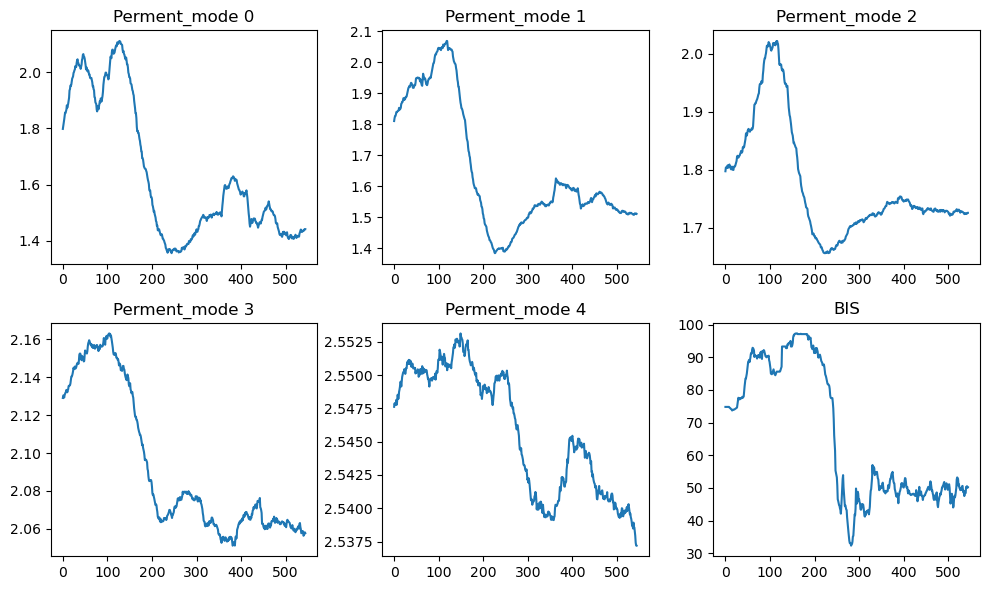

In [80]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


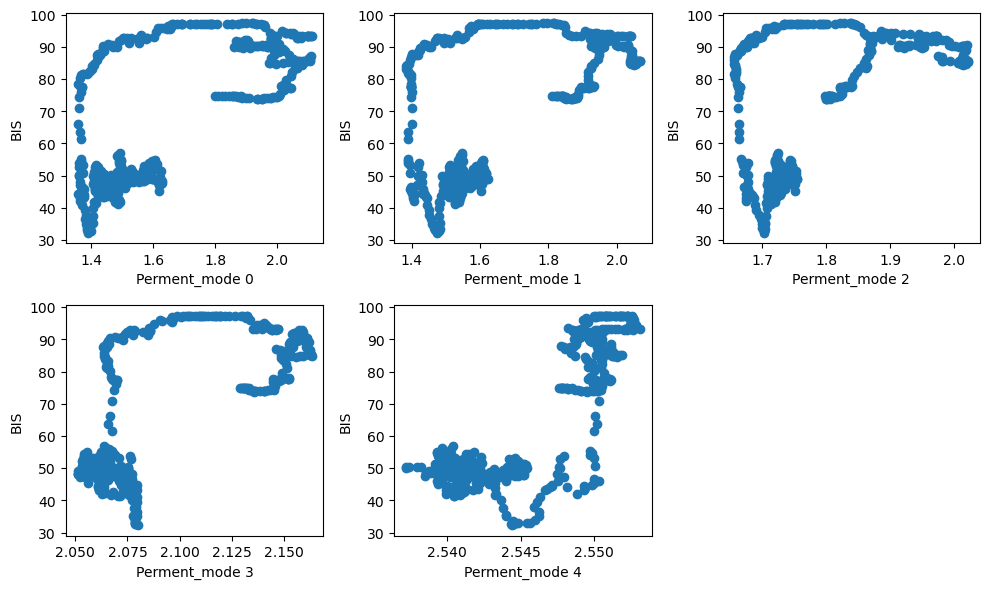

In [81]:

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].scatter(resultsp_0, bis_windows)
axes[0, 0].set_xlabel('Perment_mode 0')
axes[0, 0].set_ylabel('BIS')

# Plot on the second subplot
axes[0, 1].scatter(resultsp_1, bis_windows)
axes[0, 1].set_xlabel('Perment_mode 1')
axes[0, 1].set_ylabel('BIS')

# Plot on the third subplot
axes[0, 2].scatter(resultsp_2, bis_windows)
axes[0, 2].set_xlabel('Perment_mode 2')
axes[0, 2].set_ylabel('BIS')

axes[1, 0].scatter(resultsp_3, bis_windows)
axes[1, 0].set_xlabel('Perment_mode 3')
axes[1, 0].set_ylabel('BIS')

axes[1, 1].scatter(resultsp_4, bis_windows)
axes[1, 1].set_xlabel('Perment_mode 4')
axes[1, 1].set_ylabel('BIS')


fig.delaxes(axes[1, 2])

# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [92]:
# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


# Example usage
data = modes[1]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsd_1 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
#print(f"Number of features:", len(resultsd_1))


# Example usage
data = modes[2]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsd_2 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
#print(f"Number of features:", len(resultsd_2))


# Example usage
data = modes[3]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsd_3 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
#print(f"Number of features:", len(resultsd_3))


# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
resultsd_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
#print(f"Number of features:", len(resultsd_4))



Number of features: 545


Number of features: 0


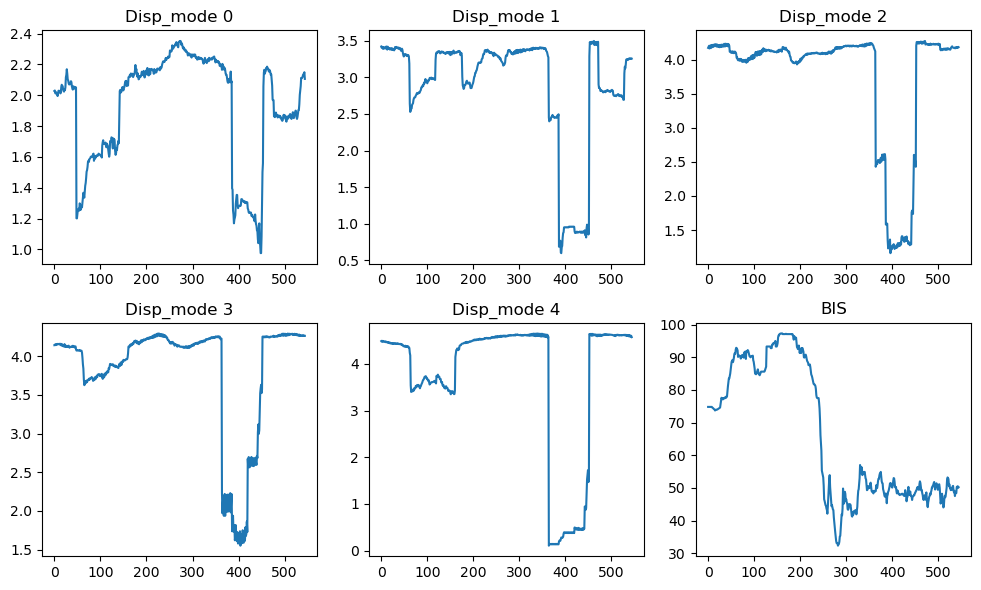

In [93]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


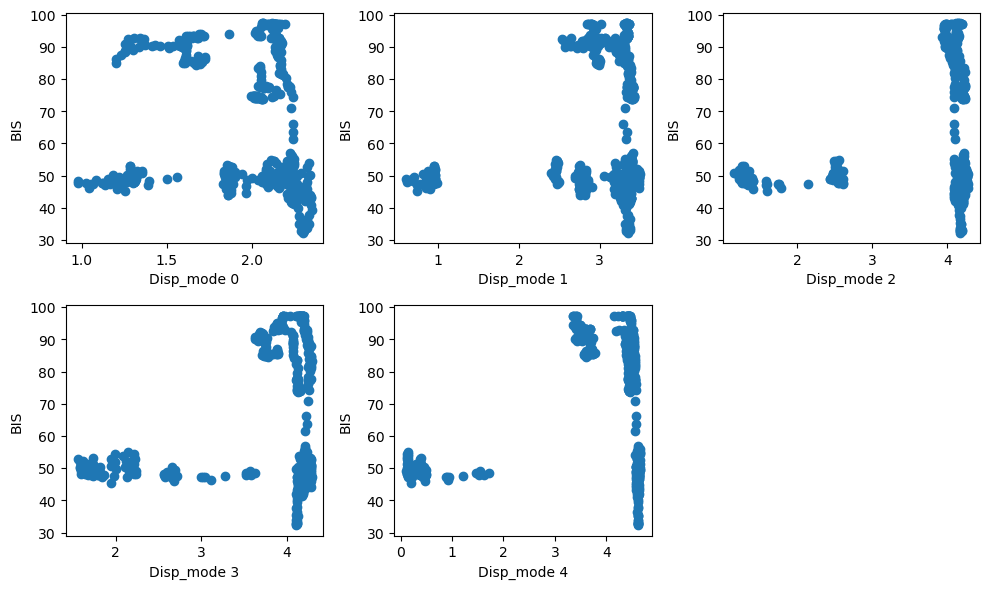

In [94]:

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].scatter(resultsd_0, bis_windows)
axes[0, 0].set_xlabel('Disp_mode 0')
axes[0, 0].set_ylabel('BIS')

# Plot on the second subplot
axes[0, 1].scatter(resultsd_1, bis_windows)
axes[0, 1].set_xlabel('Disp_mode 1')
axes[0, 1].set_ylabel('BIS')

# Plot on the third subplot
axes[0, 2].scatter(resultsd_2, bis_windows)
axes[0, 2].set_xlabel('Disp_mode 2')
axes[0, 2].set_ylabel('BIS')

axes[1, 0].scatter(resultsd_3, bis_windows)
axes[1, 0].set_xlabel('Disp_mode 3')
axes[1, 0].set_ylabel('BIS')

axes[1, 1].scatter(resultsd_4, bis_windows)
axes[1, 1].set_xlabel('Disp_mode 4')
axes[1, 1].set_ylabel('BIS')


fig.delaxes(axes[1, 2])

# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [90]:
df = pd.DataFrame({'Sampent_mode0': resultsa_0, 'Sampent_mode1': resultsa_1, 'Sampent_mode2': resultsa_2, 'Sampent_mode3': resultsa_3, 'Sampent_mode4': resultsa_4})

df['BIS']=bis_windows
df

,Sampent_mode0,Sampent_mode1,Sampent_mode2,Sampent_mode3,Sampent_mode4,BIS
0,0.046131,0.510747,0.672575,0.855030,0.929032,74.8
1,0.045788,0.509160,0.674919,0.864634,0.929916,74.8
2,0.045170,0.507674,0.674845,0.868143,0.931165,74.8
3,0.045059,0.507243,0.675302,0.864874,0.931203,74.8
4,0.044420,0.507155,0.674160,0.859561,0.936693,74.8
...,...,...,...,...,...,...
540,0.055325,0.381418,0.597250,0.687904,0.891075,50.3
541,0.055267,0.382091,0.598295,0.682242,0.889180,50.3
542,0.055271,0.381479,0.598670,0.678945,0.882266,50.5
543,0.054599,0.379802,0.598116,0.680252,0.879855,50.0


In [138]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Example data
X = pd.DataFrame({'Feature': [1, 2, 3, 4, 5]})  # Input feature dataframe
y = pd.DataFrame({'Target': [2, 4, 5, 4, 5]})  # Target variable dataframe

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Calculate the R-squared value
r_squared = model.score(X, y)

# Print the R-squared value
print("R-squared:", r_squared, X.shape)


R-squared: 0.6000000000000001 (5, 1)


In [136]:
df = series.to_frame().reset_index(drop=True)

(545,)

In [140]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Example data
X = df['Sampent_mode1'].to_frame().reset_index(drop=True)   # Input feature
y = df['BIS'] # Target variable


# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Calculate the R-squared value
r_squared = model.score(X, y)

# Print the R-squared value
print("R-squared:", r_squared)


R-squared: 0.024901021169281168


In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [122]:
metrics = {}
def plot_regression(data, column, normalize=False):
    
    global metrics
    
    X = data[column]
    X = X[:, np.newaxis]
    y = data['BIS']

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X, y)
    
    # Predictions
    y_predicted = reg.predict(X)
    
    # Show the score and r2
    mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    
    # keep track of metrics
    
    metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    # Plot the graph
    plt.figure(figsize=(10,8))
    plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
    plt.plot(X, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

C:\Users\61451\AppData\Local\Temp\ipykernel_29044\2222668525.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


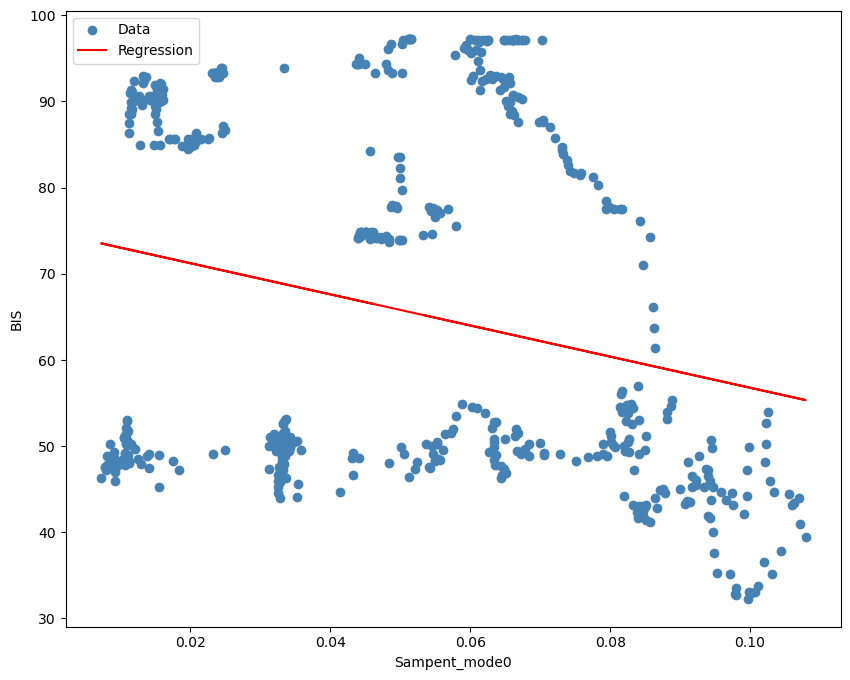

C:\Users\61451\AppData\Local\Temp\ipykernel_29044\2222668525.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


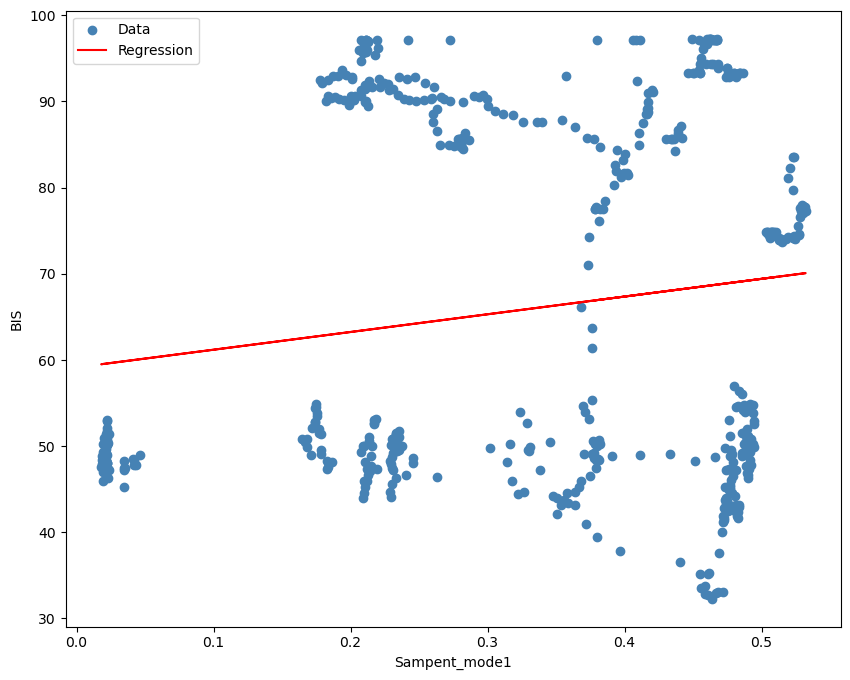

C:\Users\61451\AppData\Local\Temp\ipykernel_29044\2222668525.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


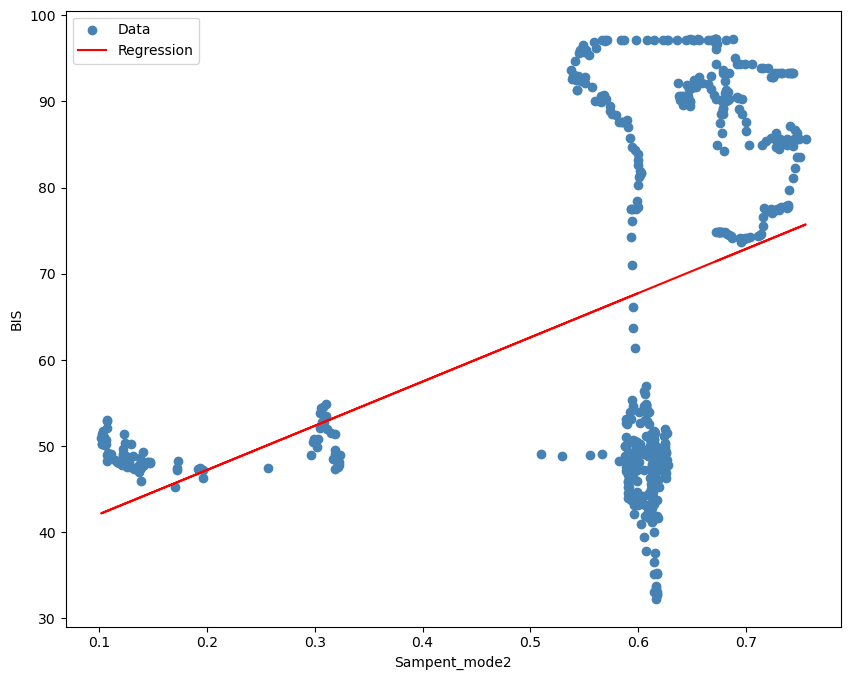

C:\Users\61451\AppData\Local\Temp\ipykernel_29044\2222668525.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


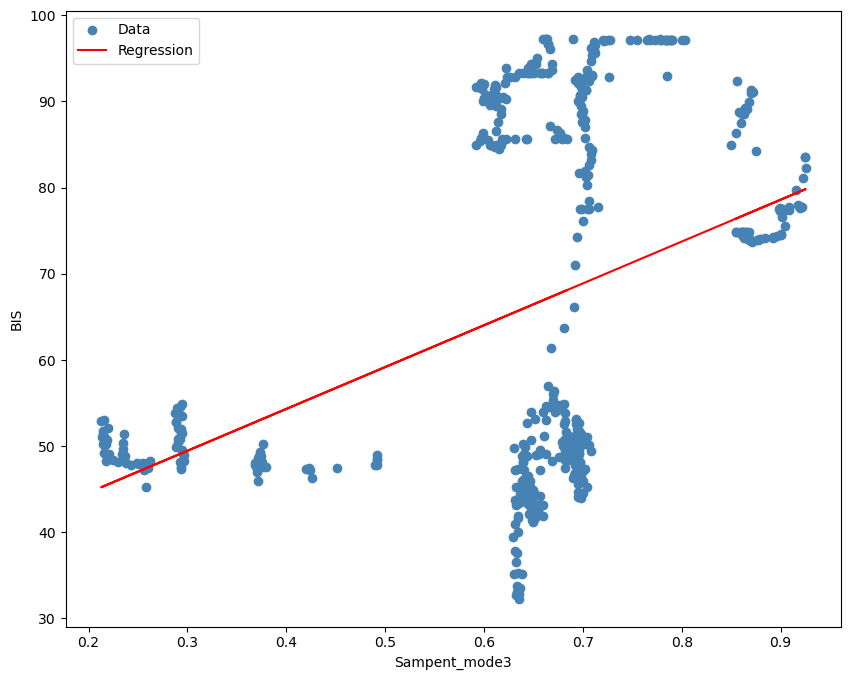

C:\Users\61451\AppData\Local\Temp\ipykernel_29044\2222668525.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


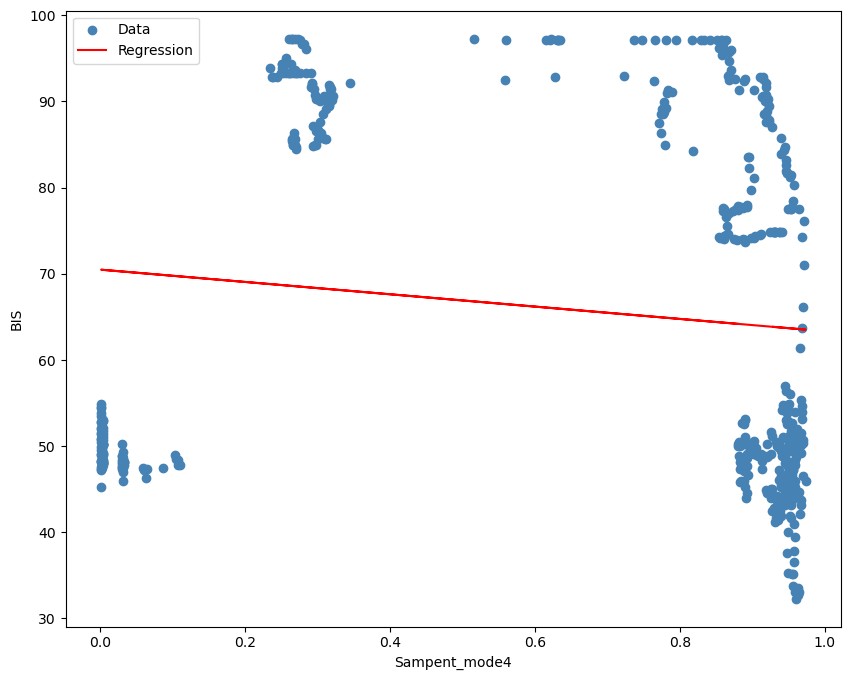

In [123]:
for column in df.columns:
    if column == "BIS":
        continue
        
    plot_regression(df, column)

In [109]:
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

,Metrics,Values
0,Sampent_mode0_mse,395.294659
1,Sampent_mode0_r2,0.065093
2,Sampent_mode1_mse,412.288317
3,Sampent_mode1_r2,0.024901
4,Sampent_mode2_mse,342.281353
5,Sampent_mode2_r2,0.190474
6,Sampent_mode3_mse,357.950930
7,Sampent_mode3_r2,0.153414
8,Sampent_mode4_mse,415.918220
9,Sampent_mode4_r2,0.016316


Number of BIS: 545


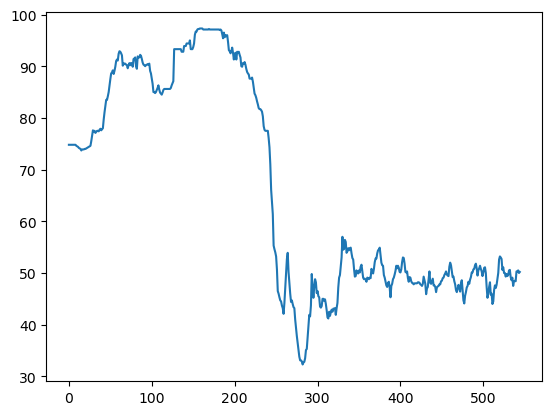

In [13]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [22]:
import numpy as np
from math import log

def dispersion_entropy(data, m, tau, alpha):
    # Phase space reconstruction
    phase_space_matrix = []
    N = len(data)
    for i in range(N - (m - 1) * tau):
        vector = [data[i + j * tau] for j in range(m)]
        phase_space_matrix.append(vector)
    phase_space_matrix = np.array(phase_space_matrix)

    # Calculate Euclidean distances
    distances = np.zeros((len(phase_space_matrix), len(phase_space_matrix)))
    for i in range(len(phase_space_matrix)):
        for j in range(len(phase_space_matrix)):
            distances[i, j] = np.linalg.norm(phase_space_matrix[i] - phase_space_matrix[j])

    # Calculate tolerance threshold
    r = alpha * np.std(distances)

    # Calculate probabilities
    probabilities = np.zeros(len(phase_space_matrix))
    for i in range(len(phase_space_matrix)):
        probabilities[i] = np.sum(distances[i] <= r) / (N - (m - 1) * tau)

    # Calculate dispersion entropy
    dispersion_entropy = -np.sum(probabilities * np.log2(probabilities))

    return dispersion_entropy

# Example usage
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
m = 2
tau = 1
alpha = 0.1

entropy = dispersion_entropy(data, m, tau, alpha)
print("Dispersion Entropy:", entropy)


Dispersion Entropy: 3.169925001442312


In [96]:
help(sp.dispersion_entropy)

Help on function dispersion_entropy in module spkit.core.infomation_theory_advance:

dispersion_entropy(x, classes=10, scale=1, emb_dim=2, delay=1, mapping_type='cdf', de_normalize=False, A=100, Mu=100, return_all=False, warns=True)
    Calculate dispersion entropy of signal x (multiscale)
    ----------------------------------------
    input:
    -----
    x      : input signal x - 1d-array of shape=(n,)
    classes: number of classes - (levels of quantization of amplitude) (default=10)
    emb_dim: embedding dimension,
    delay  : time delay (default=1)
    scale  : downsampled signal with low resolution  (default=1)  - for multipscale dispersion entropy
    mapping_type: mapping method to discretizing signal (default='cdf')
           : options = {'cdf','a-law','mu-law','fd'}
    A  : factor for A-Law- if mapping_type = 'a-law'
    Mu : factor for μ-Law- if mapping_type = 'mu-law'
    
    de_normalize: (bool) if to normalize the entropy, to make it comparable with different signa

Dispersion Entropy: [3.23459661 3.25426552 3.27495614 3.29302569 3.30885439 3.31636391
 3.32301768 3.32758097 3.3375113  3.33143793 3.32991764 3.32347962
 3.32063795 3.32626165 3.31124602 3.25245738 3.29907343 3.3321377
 3.36611716 3.4080933  3.42577572 3.43645074 3.42720261 3.39398262
 3.39354777 3.38962267 3.36971829 3.36645071 3.35095088 3.33101143
 3.30757091 3.26949884 3.23736042 3.187796   3.15961955 3.12018246
 3.09368869 3.06264632 3.03117751 3.00859678 2.99363282 2.98154997
 2.97165754 2.97482125 2.98627405 3.00461305 3.02357719 3.07631538
 3.02262598 2.74531154 2.65581857 2.72708258 2.84554003 2.95648214
 3.05125745 3.12211855 3.16717634 3.18104386 3.18087429 3.17766511
 3.17470561 3.1719512  3.17217056 3.16733315 3.17412084 3.18163337
 3.17777803 3.17067626 3.16133806 3.15423342 3.14844028 3.14499125
 3.14281633 3.1350796  3.12776785 3.11847755 3.10975227 3.10066131
 3.09142502 3.08240758 3.07260466 3.06492406 3.05879492 3.05435788
 3.05057426 3.04486365 3.04908266 3.0637718

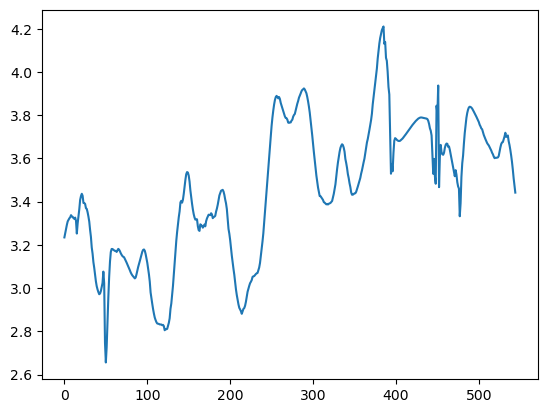

In [35]:
import numpy as np
from scipy.signal import spectrogram

def dispersion_entropy(signal, fs, windowsize, overlap):
    # Calculate spectrogram
    f, t, Sxx = spectrogram(signal, fs=fs, window='hamming', nperseg=windowsize, noverlap=overlap)

    # Calculate normalized matrix
    Sxx_norm = Sxx / np.sum(Sxx, axis=0)

    # Calculate dispersion entropy
    entropy = -np.sum(Sxx_norm * np.log(Sxx_norm + 1e-10), axis=0)
    
    return entropy

# Example usage
fs = 128  # Sampling frequency
windowsize = 56*128  # Window size
overlap = 55*128  # Overlap

# Generate random EEG signal for testing
eeg_signal = modes[0]

# Calculate dispersion entropy
disp_entropy = dispersion_entropy(eeg_signal, fs, windowsize, overlap)

print("Dispersion Entropy:", disp_entropy)
print("Dispersion Entropy:", disp_entropy.shape)
plt.plot(disp_entropy)

In [34]:
import numpy as np
from scipy.signal import spectrogram

def dispersion_entropy(signal, fs, windowsize, overlap):
    # Calculate spectrogram
    f, t, Sxx = spectrogram(signal, fs=fs, window='hamming', nperseg=windowsize, noverlap=overlap)

    # Calculate normalized matrix
    Sxx_norm = Sxx / np.sum(Sxx, axis=0)

    # Calculate dispersion entropy
    entropy = -np.sum(Sxx_norm * np.log(Sxx_norm + 1e-10), axis=0)
    
    return entropy

# Example usage
fs = 128  # Sampling frequency
windowsize = 56*128  # Window size
overlap = 55*128  # Overlap

# Generate random EEG signal for testing
eeg_signal = np.random.randn(76800)

# Calculate dispersion entropy
disp_entropy = dispersion_entropy(eeg_signal, fs, windowsize, overlap)

print("Dispersion Entropy:", disp_entropy.shape)


Dispersion Entropy: (545,)


In [70]:
# For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            sample_entropy = ant.sample_entropy(window)
            result.append(sample_entropy)


        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=10, scale=1, emb_dim=2, delay=1,return_all=False)
            result.append(Dispersion_entropy)

    return result


In [71]:
# Example usage
data = modes[4]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
resultsd_4 = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_4))


Number of features: 545


In [72]:
ty=pd.DataFrame(resultsd_4)
ty

,0
0,4.585000
1,4.585270
2,4.585375
3,4.584786
4,4.585563
...,...
540,4.583399
541,4.583317
542,4.582141
543,4.582581


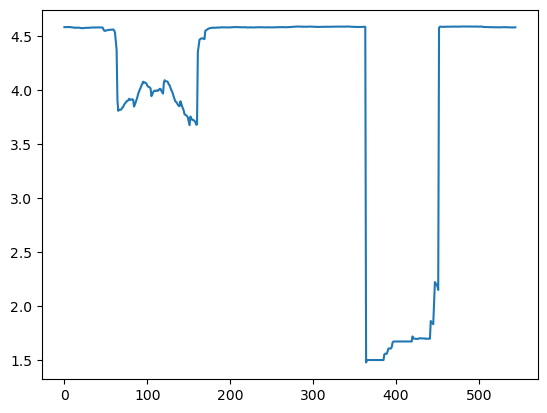

In [73]:
plt.plot(resultsd_4)

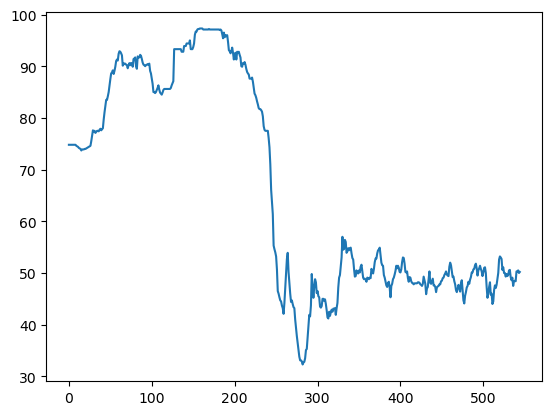

In [74]:
plt.plot(bis_windows)